### Traffic Sign Detection using the Telenav DataSet
With anchor boxes, focal loss and non max supression.
* model_version='3.0' No tuning of the resnet layer
* model_version='4.0' is unfreezing of the whole resnet layer and trained has yet yielded significant improvement over 3.0

### Get all the imports right

In [3]:
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
from PIL import Image
import numpy as np
import pandas as pd
import sys
import os
sys.path.append('/home/abhinav.sunderrajan/miniconda3/lib/python3.6/site-packages')
#fast ai stuff
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import apex
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import warnings
warnings.filterwarnings(action='once')

In [5]:
print(torch.__version__,torch.cuda.is_available())

0.4.1 True


### Setup
Read the relevant files using pandas and lets take over from there accordingly.

In [6]:
PATH='/workspace/datasets/telenav_ai_dataset/'
#PATH='/workspace/datasets/mapillary-new/'

In [7]:
labels=pd.read_csv(f'{PATH}telenav_sign_labels.csv')
#labels=pd.read_csv(f'{PATH}traffic_sign_labels_mapillary_new.csv')
bb_boxes=pd.read_csv(f'{PATH}telenav_sign_bbox.csv')
#bb_boxes=pd.read_csv(f'{PATH}traffic_sign_bbox_mapillary_new.csv')
labels.groupby(['sign']).count()

,img_name
sign,
SPEED_LIMIT_25_US,2190
SPEED_LIMIT_30_US,2342
SPEED_LIMIT_35_US,2781
SPEED_LIMIT_40_US,2803
SPEED_LIMIT_45_US,2426
SPEED_LIMIT_55_US,2343
SPEED_LIMIT_65_US,934
SPEED_LIMIT_70_US,1331
STOP_US,1819


In [8]:
labels.head()

,img_name,sign
0,471860_50ba6_19.jpg,TRAFFIC_LIGHTS_SIGN
1,504879_56d28_36.jpg,SPEED_LIMIT_40_US
2,331295_75541_5920cac878fe4.jpg,TRAFFIC_LIGHTS_SIGN
3,475460_2d71c_42.jpg,TRAFFIC_LIGHTS_SIGN
4,1289_16ada_56fed679c7e15.jpeg,TURN_RESTRICTION_LEFT_US


#### Create and save multiple bounding boxes

In [9]:
MBB_CSV = PATH+'traffic_signs_mbb.csv'
def get_box(group):
    seperator = ' '
    return pd.Series({'bbox':seperator.join(group.bbox),'count_bbox':group.shape[0]})
df_bbox=bb_boxes.groupby(['img_name']).apply(get_box)
df_bbox.reset_index(inplace=True)
df_bbox.to_csv(MBB_CSV, index=False)
print(df_bbox.shape)
df_bbox.head()

(27675, 3)


,img_name,bbox,count_bbox
0,09cfb_56df5295081ae.jpg,962 576 1141 663,1
1,10014_e0a45_578f86aae21c0.jpg,1646 1512 1890 1629 1480 3578 1688 3695,2
2,10051_adb58_5790460a2a53b.jpg,1305 2568 1421 2703,1
3,10053_2ddf1_5790486a1b320.jpg,1307 369 1440 459 1141 2486 1313 2665,2
4,10053_47b84_579048491f4ac.jpg,1076 3025 1224 3182,1


### Create and save multiclass
Watch out with apply functionsince it calls the first element twice. See link https://stackoverflow.com/questions/21390035/python-pandas-groupby-object-apply-method-duplicates-first-group. Thats why I am dropping the first element in mc list.

In [10]:
MC_CSV = PATH+'traffic_signs_multi_class.csv'
mc=[]
def get_signs(group):
    seperator = ' '
    mc.append(list(group.sign))
    return pd.Series({'sign':seperator.join(group.sign),'count_signs':group.shape[0]})

df_labels=labels.groupby(['img_name']).apply(get_signs)
df_labels.reset_index(inplace=True)
df_labels.to_csv(MC_CSV, index=False)
mc=mc[1:]
print(df_labels.shape)
df_labels.head()

(27675, 3)


,img_name,sign,count_signs
0,09cfb_56df5295081ae.jpg,TRAFFIC_LIGHTS_SIGN,1
1,10014_e0a45_578f86aae21c0.jpg,TRAFFIC_LIGHTS_SIGN TRAFFIC_LIGHTS_SIGN,2
2,10051_adb58_5790460a2a53b.jpg,TURN_RESTRICTION_LEFT_US,1
3,10053_2ddf1_5790486a1b320.jpg,TRAFFIC_LIGHTS_SIGN TURN_RESTRICTION_RIGHT_US,2
4,10053_47b84_579048491f4ac.jpg,TURN_RESTRICTION_RIGHT_US,1


In [11]:
df_bbox.loc[df_bbox['count_bbox'].idxmax()]

img_name                          25327_987eb_580554719bfe0.jpg
bbox          1884 4540 2003 4662 1812 4256 2135 4447 841 24...
count_bbox                                                    7
Name: 3897, dtype: object

### Prepare dataloader for image labels

In [12]:
id2cats=list(labels.sign.unique())
cats2id = {v:k for k,v in enumerate(id2cats)}

In [13]:
trn_fns={(k+1):v for k,v in enumerate(df_labels.img_name.unique())}
mcs = np.array([np.array([cats2id[p] for p in o]) for o in mc])

### Get validation set
20 percent of the dataset by default.

In [14]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

## Setup Dataset

In [15]:
f_model=resnet34
#the number of filters is 512 for resnet34 and 2048 for resnet50
n_filters=512
sz=512
bs=32
jaccard_overlap=0.4
model_version='5.0'

In [16]:
#for bounding box
aug_tfms = [#RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
#md = ImageClassifierData.from_csv(PATH, 'train_data', MBB_CSV,bs=bs, tfms=tfms, continuous=True)
md = ImageClassifierData.from_csv(PATH, 'train_data', MBB_CSV,bs=bs, tfms=tfms, continuous=True)

In [17]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

### Get a feel of the batch sizes and shape of the input tensors and also plot them ground truths

In [18]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [19]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)
print(x.shape)

(32, 512, 512, 3)


In [20]:
print(y[0].shape,y[1].shape)

(32, 16) (32, 4)


## Plots

In [21]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [22]:
def bb_to_hw(bb):
    return [bb[1],bb[0],bb[3]-bb[1], bb[2]-bb[0]]

def show_img(im, figsize=None, axis=None):
    if not axis:
        fig,axis = plt.subplots(figsize=figsize)
    axis.imshow(im)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    return axis

def draw_outline(obj,lw):
    obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(axis, box, color='white'):
    patch = axis.add_patch(patches.Rectangle(box[:2],box[-2],box[-1],fill=False,edgecolor=color,lw=2))
    draw_outline(patch,4)
    
def draw_text(axis,xy,text,text_size=14, color='white'):
    patch = axis.text(*xy, text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
    draw_outline(patch,1)
    
def show_img_all(id_img):
    img = open_image(IMG_PATH/imgs_fn[id_img])
    axis = show_img(img, figsize=(16,8))
    for bbox, id_cat in trn_anno[id_img]:
        new_box = bb_to_hw(bbox)
        draw_rect(axis, new_box)
        draw_text(axis, new_box[:2], cats[id_cat])
        
def show_ground_truth(ax, im, bbox, clas = None, prs = None, tresh = 0.3):
    bb = [bb_to_hw(o) for o in bbox.reshape(-1,4)]
    if clas is None: clas = [None] * len(bb)
    if prs is None: prs = [None] * len(bb)
    ax = show_img(im,axis=ax)
    for i, (b,c,pr) in enumerate(zip(bb,clas,prs)):
        if b[2] > 0 and (pr is None or pr > tresh):#Show the bow only if there is something to show
            draw_rect(ax, b, colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c == len(id2cats) else id2cats[c])
            if pr is not None: txt += f'{pr:.2f}'
            draw_text(ax,b[:2],txt,color=colr_list[i%num_colr])
        
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*sz).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

def np_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, (bbox*sz).astype(np.uint8),
         clas, prs if prs is not None else None, thresh)

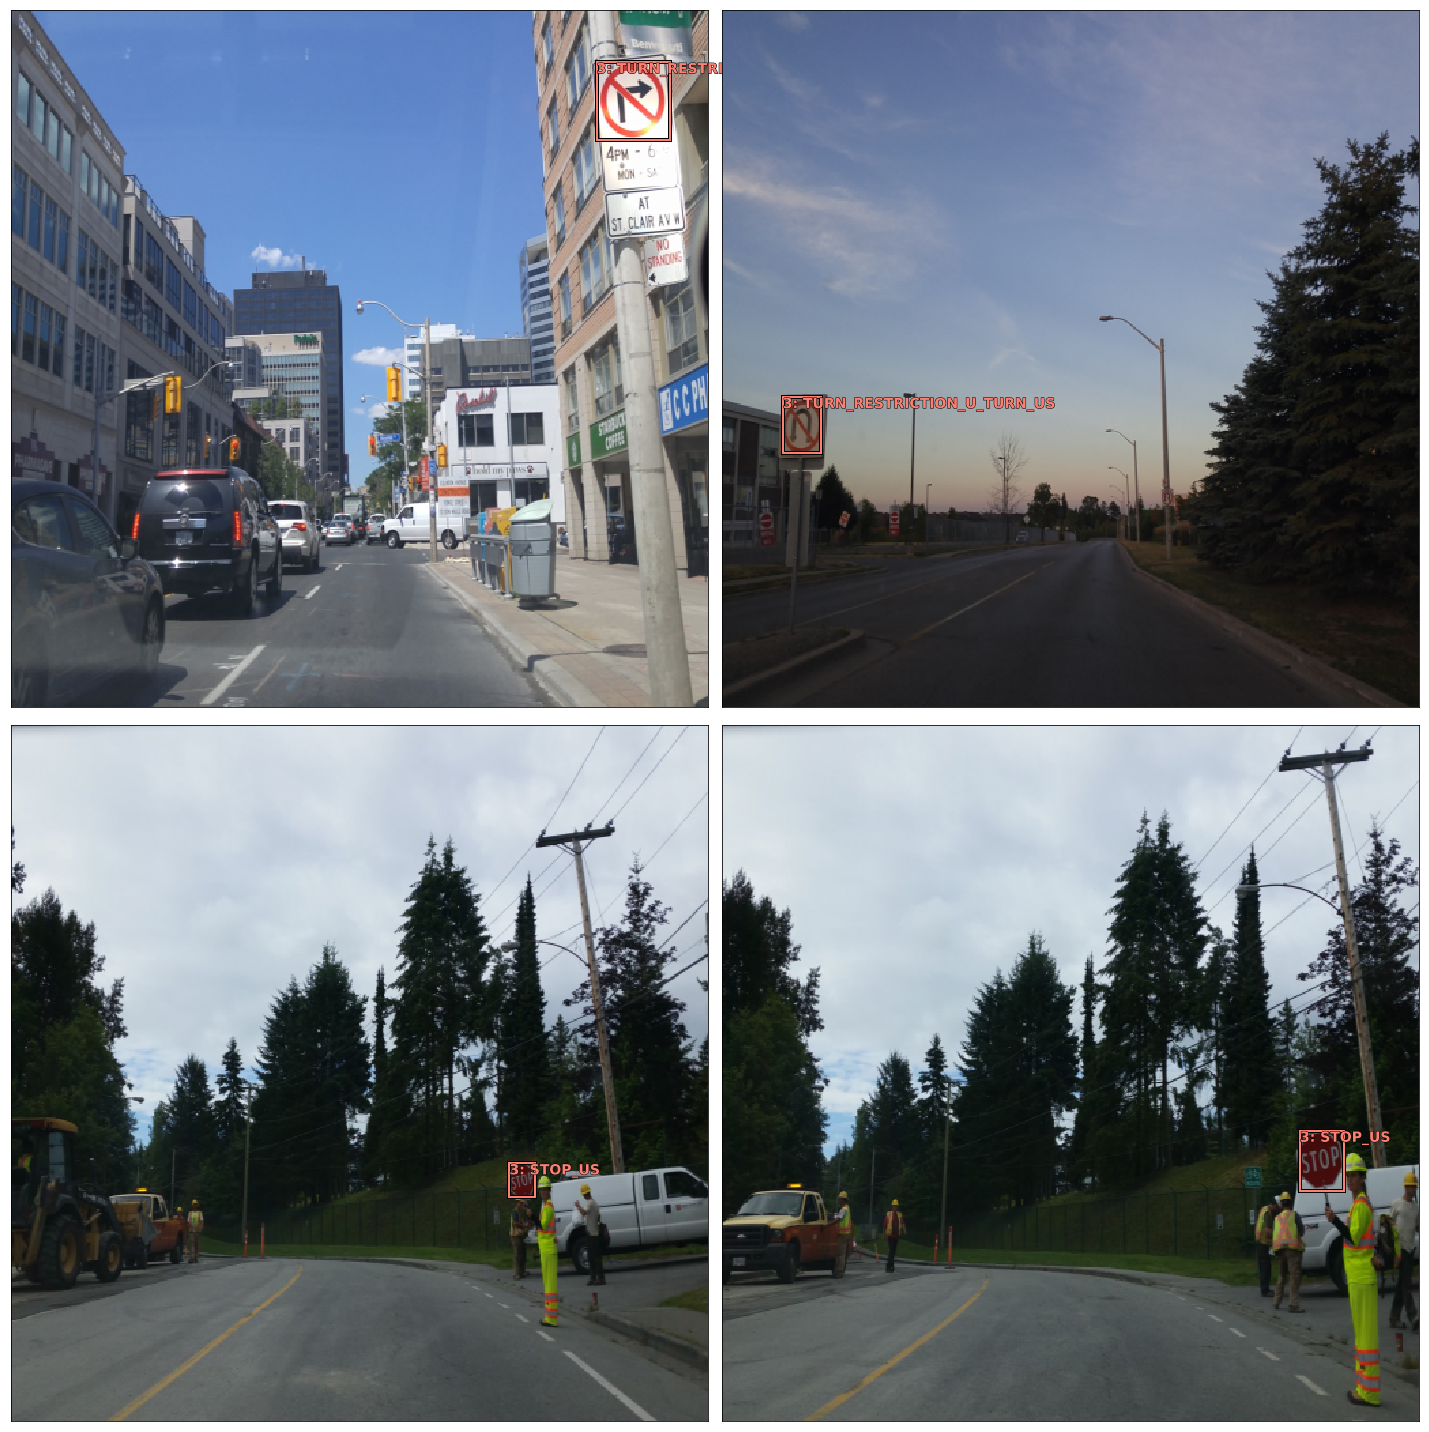

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i+2], y[0][i+2], y[1][i+2])
plt.tight_layout()

## Model and anchors

In [24]:
def hw2corners(ctr, hw): 
    return torch.cat([ctr-hw/2,ctr+hw/2], dim=1)

In [25]:
anc_grids = [8,4,1]
#anc_grids = [4]
anc_zooms = [0.25,0.75,1.0,1.5]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
#k is the number of zooms multiplied by the number of aspect ratios
print(k)

12


### Feature Pyramid Networks (FPN)
CHeck out this mice blog post https://medium.com/@jonathan_hui/what-do-we-learn-from-single-shot-object-detectors-ssd-yolo-fpn-focal-loss-3888677c5f4d

In [26]:
class StdConv(nn.Module):
    def __init__(self, n_in,n_out,stride=2,padding=1,dp = 0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in,n_out,3,stride=stride,padding=padding)
        self.bn = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(dp,inplace=True)
        
    def forward(self,x):
        return self.dropout(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

### What is out conv?
Outconv essentially returns two convolutional layers one of size number_of_cateories (*k) plus one for background to sepcialize in object categorization and the other of size 4 (*k) for the bounding box detection.

In [27]:
class OutConv(nn.Module):
    def __init__(self, k, n_in, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(n_in, (len(id2cats)+1) * k, 3, padding=1)
        self.oconv2 = nn.Conv2d(n_in, 4 * k, 3, padding = 1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [28]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop,inplace=True)
        self.sconv1 = StdConv(n_filters,256, dp=drop)
        self.sconv2 = StdConv(256,256, dp=drop)
        self.sconv3 = StdConv(256,256,padding=0,dp=drop)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

### Loss function
Focal loss from the retina net paper

In [29]:

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, preds, targets):
        t = one_hot_embedding(targets, self.num_classes+1)
        t = V(t[:,:-1].contiguous()) #bg class is predicted when none of the others go out.
        x = preds[:,:-1]
        w = self.get_weight(x,t)# for the last part
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self,x,t):
        return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cats))

#### IOU and jaccard

In [30]:
def intersection(box_a,box_b):
    min_xy = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    max_xy = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp(max_xy-min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]

def get_size(box):
    return (box[:,2]-box[:,0]) * (box[:,3] - box[:,1])

def jaccard(box_a,box_b):
    inter = intersection(box_a,box_b)
    union = get_size(box_a).unsqueeze(1) + get_size(box_b).unsqueeze(0) - inter
    return inter/union

In [31]:
#Removes the zero padding in the target bbox/class
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2] - bbox[:,0])>0.).nonzero()[:,0]
    #print(bbox)
    #print(clas)
    #print('--------------------------------------')
    return bbox[bb_keep], clas[bb_keep]


def actn_to_bb(actn, anchors):
    """
    interpreting activations and converting them to bouding boxes. 
    The method is the short form for activations to bounding boxes.
    """
    actn_bbs = torch.tanh(actn)
    actn_ctrs = (actn_bbs[:,:2] * grid_sizes/2) + anchors[:,:2]
    actn_hw = (1 + actn_bbs[:,2:]/2) * anchors[:,2:]
    return hw2corners(actn_ctrs,actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False, use_ab=True):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, (anchor_cnr if use_ab else a_ic).data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > jaccard_overlap
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cats)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

def ssd_loss2(pred,targ):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,use_ab=False)
        lls += loc_loss
        lcs += clas_loss
    return lls+lcs

In [41]:
head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
#learn.half()
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [42]:
??learn.fp16

## Model training
Run this block only when you train a model. If you have a pretrained model skip and move to the subsequent steps.
##### Note that model traning takes 10 minutes per epoch on an average

In [ ]:
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=1)

  0%|          | 0/692 [00:00<?, ?it/s]

In [ ]:
lr = 5e-3
lrs = np.array([lr/100,lr/10,lr])
learn.fit([lr,lr/5,lr/10], 1, cycle_len=18, use_clr=(32,5))
learn.sched.plot_lr()

### Use differential learning rates
Now start tuning the resnet block. I set very low learning rates for the first few layers which progressively increases as we start approaching the custom head  i.e. the Feature Pyramid Networks (FPN).

In [ ]:
#unable unfreeze resnet50 due to out of memory exceptions
learn.unfreeze()
#learn.freeze_to(-2)
learn.fit(lrs/10, 1, cycle_len=20, use_clr=(32,5))

In [ ]:
learn.save(f'mapillary-{sz}-{bs}-atleast-900-{model_version}')

In [ ]:
print(f'saved model mapillary-{sz}-{bs}-atleast-900-{model_version}')

## NMS
Nonmax supression

In [ ]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

### Evaluate the model

In [ ]:
#learn.load(f'telenav-{sz}-{bs}-atleast-900-{model_version}')
learn.load(f'mapillary-{sz}-{bs}-atleast-900-{model_version}')
learn.model.eval()

### Predict on a minibatch in the validation set

In [ ]:
batch_num=2
i=0
x=None
y=None
for data in md.val_dl:
    if i==batch_num:
        x,y = data
        x,y = V(x),V(y)
        break
    i=i+1    
pred = learn.model(x)

In [ ]:
jaccard_overlap=0.4
def get1preds(b_clas,b_bb,bbox,clas,thresh=0.25):
    bbox,clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    clas_pr, clas_ids = b_clas.max(1)
    conf_scores = b_clas.sigmoid().t().data
    out1,out2,cc = [],[],[]
    for cl in range(conf_scores.size(0)-1):
        cl_mask = conf_scores[cl] > thresh
        if cl_mask.sum() == 0: continue
        scores = conf_scores[cl][cl_mask]
        l_mask = cl_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, jaccard_overlap, 1)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc)) if cc != [] else None
    out1 = torch.cat(out1) if out1 != [] else None
    out2 = torch.cat(out2) if out2 != [] else None
    return out1,out2,cc

In [ ]:
def show_results(idx, thresh=0.25, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(figsize=(6,6))
    ax.title.set_text("Model results")
        
    ima=md.val_ds.ds.denorm(x)[idx]
    out1,out2,cc = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],thresh)
    torch_gt(ax, ima, out2, cc, out1, thresh)
    
def show_gt(idx, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(figsize=(6,6))
    ax.title.set_text("Ground truth")
    ima = md.val_ds.ds.denorm(x)[idx]
    show_ground_truth(ax,ima,to_np(y[0][idx]),to_np(y[1][idx]))
    
def compare(idx,thresh=0.5):
    fig, axs = plt.subplots(2,1,figsize=(6,12))
    show_results(idx,thresh,ax=axs[0])
    show_gt(idx,ax=axs[1])
    plt.tight_layout()

In [ ]:
idx=26
compare(idx,thresh=0.2)

### Visualizing the anchor boxes
if you want to.

In [ ]:
#b_clas,b_bb = pred
#idx=7
#b_clasi = b_clas[idx]
#b_bboxi = b_bb[idx]
#ima=md.val_ds.ds.denorm(to_np(x))[idx]
#bbox,clas = get_y(y[0][idx], y[1][idx])

#fig, ax = plt.subplots(figsize=(17,17))
#torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])


## Mean average precision
Calculate the mean average precision of your classifier. See the link below for a wonderful tutorial on it.

https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3

In [ ]:
def count(L):
    result = collections.defaultdict(int)
    if L is not None:
        for x in L:
            result[x] += 1
    return result

In [ ]:
count([1,14,1,14,1,2,3,5,5])

In [ ]:
min_overlap=0.25

In [ ]:
from ipywidgets import FloatProgress
from IPython.display import display
def multiTPFPFN():
    n = 40
    threshes = np.linspace(0.001, 0.95, n, endpoint=True)
    tps,fps,fns = np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats)))
    prog = FloatProgress(min=0,max=len(md.val_dl))
    display(prog)
    for data in md.val_dl:
        x,y = data
        x,y = V(x),V(y)
        pred = learn.model(x)
        for idx in range(x.size(0)):
            bbox,clas = get_y(y[0][idx],y[1][idx])#unpad the target
            p_scrs,p_box,p_cls = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],threshes[0])
            overlaps = to_np(jaccard(p_box,bbox.data))
            overlaps = np.where(overlaps > min_overlap, overlaps, 0)
            clas, np_scrs, np_cls = to_np(clas.data),to_np(p_scrs), to_np(p_cls)
            for k in range(threshes.shape[0]):
                new_tp = collections.defaultdict(int)
                for cls in list(set(clas)):
                    msk_clas = np.bitwise_and((clas == cls)[None,:],(np_cls == cls)[:,None])
                    ov_clas = np.where(msk_clas,overlaps,0.)
                    mx_idx = np.argmax(ov_clas,axis=1)
                    for i in range(0,len(clas)):
                        if (clas[i] == cls):
                            keep = np.bitwise_and(np.max(ov_clas,axis=1) > 0.,mx_idx==i)
                            keep = np.bitwise_and(keep,np_scrs > threshes[k])
                            if keep.sum() > 0:
                                new_tp[cls] += 1
                count_pred = count(np_cls[np_scrs > threshes[k]])
                count_gt = count(clas)
                for c in range(len(id2cats)):
                    tps[k,c] += new_tp[c]
                    fps[k,c] += count_pred[c] - new_tp[c]
                    fns[k,c] += count_gt[c] - new_tp[c]
        prog.value += 1 
    return tps, fps, fns

In [ ]:
%time tps, fps, fns = multiTPFPFN()

In [ ]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
cmap = plt.get_cmap('jet_r')
N=len(id2cats)
def plot_prec_recall(clas):
    color = cmap(float(i)/N)
    prec = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
    recal = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
    plt.plot(recal,prec,label=id2cats[clas],c=color,linewidth=3.0)
    plt.legend()

In [ ]:
for i in range(0,len(id2cats)):
    plot_prec_recall(i)

In [ ]:
def avg_prec(clas):
    precisions = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
    recalls = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    return np.array(prec_at_rec).mean()

In [ ]:
def mAP():
    S = 0
    for i in range(len(id2cats)):
        S += avg_prec(i)
    return S/len(id2cats)

### Report mAP
map much better now

In [ ]:
mAP()

In [ ]:
??learn.fit

In [ ]:
learn.model.parameters